In [1]:
import pyarrow.parquet as pq
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import keras
print(keras.__version__)
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
from keras.callbacks import LambdaCallback,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from math import sqrt
from sklearn.metrics import confusion_matrix,f1_score,matthews_corrcoef,fbeta_score,precision_score,recall_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn
from sklearn.utils import class_weight
from datetime import datetime,timedelta

Using TensorFlow backend.


2.3.1
2.0.0-rc1


In [2]:
df = pq.read_table(source='integratedData.parquet.gz').to_pandas()
display(df.head())

,date,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,dead_fuel_moisture_1000hr_Percent,energy_release_component-g_Unitless,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,fire_occurred,acres_burned,fire_name,longitude,latitude
0,1999-01-01,0.0,40.3,0.00589,138.0,123.0,1.6,293.1,281.1,24.0,16.0,15.5,34.0,1.7,0.74,False,NaN,None,-117.975000,33.566667
1,1999-01-01,0.0,39.8,0.00590,137.2,123.0,1.6,293.1,281.2,24.0,16.0,15.5,35.0,1.7,0.74,False,NaN,None,-117.933333,33.566667
2,1999-01-01,0.0,38.2,0.00580,137.2,123.0,1.7,293.2,281.2,26.0,15.2,14.9,37.0,1.7,0.77,False,NaN,None,-117.891667,33.566667
3,1999-01-01,0.0,36.4,0.00567,137.3,49.0,1.8,293.3,280.3,27.0,15.0,14.8,38.0,1.8,0.76,False,NaN,None,-117.850000,33.566667
4,1999-01-01,0.0,33.8,0.00538,137.3,49.0,1.9,293.2,279.9,29.0,13.3,13.6,43.0,1.9,0.80,False,NaN,None,-117.808333,33.566667


In [3]:
###********Check Fire occured in Months to drop some months of data********
fire_occured_df = df[df['fire_occurred']==True]
month_list = [0,0,0,0,0,0,0,0,0,0,0,0]
for item in fire_occured_df['date']:
    month_list[item.month-1] = month_list[item.month-1]+ 1;
print ("Fire Occurence in Each month across years")
print (month_list)

Fire Occurence in Each month across years
[14, 13, 9, 6, 217, 122, 296, 148, 87, 1220, 6, 29]


In [4]:
df_sorted = df.sort_values(['latitude', 'longitude','date'], ascending=[True,True,True])
df_sorted['month'] = df_sorted.apply(lambda row: row.date.month, axis = 1)
df_sorted['day']   = df_sorted.apply(lambda row: row.date.day, axis = 1)
#df_upd = df_sorted[(df_sorted['month']>4) & (df_sorted['month']<11)]

In [5]:
df_upd = df_sorted.reindex(columns= ['precipitation_amount_mm','relative_humidity_%','specific_humidity_kg/kg', \
 'surface_downwelling_shortwave_flux_in_air_W m-2','wind_from_direction_Degrees Clockwise from north', \
 'wind_speed_m/s','max_air_temperature_K', 'min_air_temperature_K','burning_index_g_Unitless', \
 'dead_fuel_moisture_100hr_Percent','dead_fuel_moisture_1000hr_Percent','energy_release_component-g_Unitless', \
 'potential_evapotranspiration_mm','mean_vapor_pressure_deficit_kPa',
 'longitude','latitude','month','day','fire_occurred','acres_burned','fire_name','date'])
df_upd.fire_occurred = df_sorted.fire_occurred.astype(int)
df_upd.head()

,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,...,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,longitude,latitude,month,day,fire_occurred,acres_burned,fire_name,date
1268,0.0,49.5,0.00653,155.3,348.0,2.6,290.7,281.0,26.0,17.2,...,1.7,0.47,-117.141667,32.483333,1,1,0,NaN,None,1999-01-01
2660,0.0,54.3,0.00656,157.5,358.0,2.3,291.3,281.1,24.0,17.2,...,1.7,0.51,-117.141667,32.483333,1,2,0,NaN,None,1999-01-02
4052,0.0,41.1,0.00581,160.8,38.0,3.3,293.4,279.9,29.0,16.8,...,2.4,0.73,-117.141667,32.483333,1,3,0,NaN,None,1999-01-03
5444,0.0,23.9,0.00437,160.7,62.0,2.3,295.4,281.9,28.0,14.6,...,2.6,1.20,-117.141667,32.483333,1,4,0,NaN,None,1999-01-04
6836,0.0,24.1,0.00556,160.7,347.0,2.5,294.4,282.2,30.0,13.2,...,2.4,0.94,-117.141667,32.483333,1,5,0,NaN,None,1999-01-05


In [6]:
undersample_grid_dict= {}
with open('log.txt', 'w') as f:
    lats = sorted(set(df_upd.latitude.values))
    lons = sorted(set(df_upd.longitude.values))

    loc_count = 0
    Fire_loc_count = 0
    NoFire_loc_count = 0
    for i in lats:
        for j in lons:
            mask = (df_upd['latitude']==i) & (df_upd['longitude']==j)
            if not df_upd[mask].empty:
                loc_count += 1;
                if 1 in df_upd[mask]['fire_occurred'].values:
                    Fire_loc_count += 1;
                else:
                    if i not in undersample_grid_dict.keys():
                        undersample_grid_dict[i] = []
                    if j not in undersample_grid_dict[i]:
                        undersample_grid_dict[i].append(j)
#                     print ("Dropping all data at ",i,j,file=f)
#                     df_upd.drop(sorted(df_upd[mask].index),inplace=True)
                    NoFire_loc_count += 1;

    print("Total grids are ",loc_count)
    print("Grids that had Fire", Fire_loc_count)
    print("Grids that didn't have Fire", NoFire_loc_count)

Total grids are  890
Grids that had Fire 478
Grids that didn't have Fire 412


In [7]:
undersample_grid_dict

{32.483333333333334: [-117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667],
 32.525000000000006: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667,
  -116.64166663333334,
  -116.59999996666667,
  -116.55833330000002,
  -116.51666663333334,
  -116.47499996666667,
  -116.43333330000002],
 32.56666666666667: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.47499996666667,
  -116.43333330000002,
  -116.22499996666667,
  -116.18333330000002,
  -116.14166663333334,
  -116.09999996666667,
  -116.05833330000002],
 32.608333333333334: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667],
 32.650000000000006: [-117.26666663333334,
  -117.22499996666667,
  -117.18333330000002,
  -117.14166663333334,


In [8]:
df_upd.shape

(6826300, 22)

In [9]:
df_mod = df_upd.reset_index(drop=True)
#df_mod = df_upd

In [10]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
x =     df_mod[df_mod.columns[~df_mod.columns.isin(['fire_occurred','acres_burned','fire_name','date'])]].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)
#norm_Df = pd.DataFrame(data = norm_x, columns = columns)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
#This function is called upon if the seq has fire and accordingly adds it to that fire group
def append_to_fire_seq(fire_dict,i,df_mod,lag):
#    print (i,len(fire_dict))
    idx = i + np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0][0]
    fire_name = df_mod.iloc[idx]['fire_name']
    check_date = pd.Timestamp.to_datetime64(df_mod.iloc[idx]['date'])
    if fire_name!=None:
        fire_name = str(df_mod.iloc[idx]['date'].year) + "_" + fire_name.lower() 
        if fire_name not in fire_dict.keys():
            fire_dict[fire_name] = []
#         if len(fire_dict[fire_name])!=0:
#             check_date2 = fire_dict[fire_name][0][0][-1]
#             #if ((check_date2-check_date).astype('timedelta64[D]')/np.timedelta64(1, 'D')) < -20:
#             if (check_date2 - check_date).days < -30:
#                 print ("Pls check this fire list", fire_name , "Seems fires occured more than 30 days apart")
        fire_dict[fire_name].append(df_mod.iloc[idx-lag:idx].values)
        fire_dict[fire_name].append(df_mod.iloc[idx]['fire_occurred'])
    else:
        print ("No Name for this fire happened in from ",idx-lag)

In [12]:
def undersample(lat,lon,year,month):
    undersample_grid_year_dict = {}
    if lat in undersample_grid_dict.keys():
        if lon in undersample_grid_dict[lat]:  #Grid never had fire. Let's add only one seq per month
            if (lat,lon) not in undersample_grid_year_dict.keys():
                undersample_grid_year_dict[(lat,lon)]= {}
            if year not in undersample_grid_year_dict[(lat,lon)].keys():
                undersample_grid_year_dict[(lat,lon)][year] = []   #This month and year for this Grid is seen first time.
            if month not in undersample_grid_year_dict[(lat,lon)][year]:
                undersample_grid_year_dict[(lat,lon)][year].append(month)
                #print (lat,lon,year,month)
                return 1
            else:
                return 0
    return 1    

In [13]:
#This function breaks the total dataset into small sequences
def create_seq(df_mod,lag):    
    print ("Every sequence will be",lag, "days long asking LSTM to predict a fire based on past",lag,"days of weather")
    global nofire_X,nofire_y,fire_dict
    nofire_X = []
    nofire_y = []
    fire_dict = {}
    for i in range(0,df_mod.shape[0],lag):
        if i+lag in df_mod.index:
            fire_occur_list = list(df_mod.iloc[i:i+lag].fire_occurred.values)
            if fire_occur_list.count(1)==1:          #Fire in Sequence
                append_to_fire_seq(fire_dict,i,df_mod,lag)
            elif fire_occur_list.count(1)==0:        #No Fire in Sequence
                if undersample(df_mod.iloc[i]['latitude'],df_mod.iloc[i]['longitude'],df_mod.iloc[i]['date'].year,df_mod.iloc[i]['month'])==1:
                    nofire_X.append(df_mod.iloc[i:i+lag].values)
                    nofire_y.append(df_mod.iloc[i+lag]['fire_occurred'])
            else:                                   #More than one fire in sequence. Maybe same or different fires
                indices = np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0]
                for item in indices:
                    append_to_fire_seq(fire_dict,i+item,df_mod,lag)
        else:
            print ("Can't create sequence from this index onwards", i)

In [14]:
#This function is called to retrieve sequences of a specific fire
def add_fire_seq_train_test (fire_names):
    X_list= []
    for fire in fire_names:
        for idx in range(0,len(fire_dict[fire]),2):
            X_list.append(fire_dict[fire][idx])
            if fire_dict[fire][idx+1]!=1:
                print ("Error: This is unexpected. Check the fire sequence for fire ", fire)
    return X_list

In [15]:
#This function is called to shuffle sequences of fire with no fire
def comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train):
    a_len = len(nofire_X_train)
    b_len = len(fire_X_train)
    a_cnt = -1
    b_cnt = -1
    out_x_list = []
    out_y_list = []
    my_list = [0]*len(nofire_X_train) + [1]*len(fire_X_train)
    random.shuffle(my_list)
    for i in my_list:
        if i==0:
            a_cnt += 1
            out_x_list.append(nofire_X_train[a_cnt])
            out_y_list.append(nofire_y_train[a_cnt])
        else:
            #print (a_cnt,b_cnt)
            b_cnt += 1
            out_x_list.append(fire_X_train[b_cnt])
            out_y_list.append(fire_y_train[b_cnt])
    return out_x_list,out_y_list

In [16]:
def train_test_partition(test_year):
    nofire_X_train = []
    nofire_X_test  = []
    nofire_y_train = []
    nofire_y_test  = []
    test_fire_list = []
    train_fire_list = []
    for idx,seq in enumerate(nofire_X):
        if seq[0,-1].year==test_year:
            nofire_X_test.append(seq)
            nofire_y_test.append(nofire_y[idx])
        else:
            nofire_X_train.append(seq)
            nofire_y_train.append(nofire_y[idx])
    for item in sorted(fire_dict.keys()):
        if int(item.split('_')[0]) == test_year:
            test_fire_list.append(item)
        else:
            train_fire_list.append(item)
    fire_X_train = []
    fire_X_test  = []
    fire_X_train = fire_X_train + add_fire_seq_train_test(train_fire_list)
    fire_X_test = fire_X_test + add_fire_seq_train_test(test_fire_list)
    fire_y_train = [1] * len(fire_X_train)
    fire_y_test  = [1] * len(fire_X_test)
    print ("No. of Fires in Train set are", len(train_fire_list))
    print ("No. of Fire sequences in Train set are", len(fire_X_train))
    print ("No. of no-fire sequences in Train set are", len(nofire_X_train))
    print ("No. of Fires in Test set are", len(test_fire_list))
    print ("No. of Fire sequences in Test set are", len(fire_X_test))
    print ("No. of no-fire sequences in Test set are", len(nofire_X_test))
    print ("Fires in Test are",test_fire_list)
    A,B = comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train)
    C,D = comb_fire_and_nofire(nofire_X_test,fire_X_test,nofire_y_test,fire_y_test)
    return A,B,C,D

In [17]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [18]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [19]:
def train_model(X_train,X_test,y_train,y_test,input_node,hidden_node,hidden_node1,dropout,class_weight,loss_funtion,alpha,gamma,lag):
    input=()
    ##Build LSTM Model
    global model
    model = Sequential()
    model.add(LSTM(input_node, input_shape=(X_train[0].shape),activation='relu'))
    model.add(Dense(hidden_node, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_node1, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation = 'softmax'))
    if (loss_funtion=='binary_crossentropy'):
        model.compile(loss='binary_crossentropy', optimizer='adam')     
    else:
        model.compile(loss=binary_focal_loss(alpha=alpha,gamma=gamma),optimizer='adam')
    #Fit the model
    train_label = np.array(y_train)
    y_invtrain = [1 - crap for crap in y_train]
    train_label_inv = np.array(y_invtrain)
    train_label_np = np.array((train_label_inv,train_label), order='F').T

    history = model.fit(np.array(X_train),train_label_np,
                            epochs=25,validation_split = 0.1,
                            verbose=2, shuffle=True,
                            callbacks = [EarlyStopping(monitor='val_loss', patience=6, verbose=1,restore_best_weights=True)],
                            class_weight=class_weight)
    #Visualize Training
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training pattern')
    plt.legend()
    # make a prediction
    global y_pred, y_ppredt
    y_pred = model.predict(np.array(X_test))
    #Measure metrics
    y_ppredt=[]
    for i in y_pred:
        if i[0]<i[1]:
            y_ppredt.append(1)
        else:
            y_ppredt.append(0)
    f1 = f1_score(y_test, y_ppredt, average='macro')
    f2 = fbeta_score(y_test, y_ppredt, average='macro', beta=2)
    mcc = matthews_corrcoef(y_test, y_ppredt)
    disp = confusion_matrix(y_test,y_ppredt,labels=[1,0])
    with open("test.csv", "a") as myfile:
        temp_string = "****Building LSTM of lag\t" + str(lag) + ";" \
                      "with input_node\t" + str(input_node)  + ";" \
                      "and hidden_node\t" + str(hidden_node) + ";" \
                      "and hidden_node1\t" + str(hidden_node1) + ";" \
                      "and dropout\t" + str(dropout) + "," \
                      "and class_weight\t" + str(class_weight) + ";" \
                      "and loss_funtion\t" + str(loss_funtion) + ";" \
                      "of alpha\t" + str(alpha) + ";"\
                      "and gamma\t" + str(gamma) + ";" \
                      "and received F1_Score:\t" + str(f1) + ";" \
                      "and received F2_Score:\t" + str(f2) + ";" \
                      "and MCC_Score:\t" + str(mcc) + ";" \
                      "of CM\t" + str(disp).replace('\n', '') + ";" + "\n"
        myfile.write(temp_string)
        print (temp_string)
    skplt.metrics.plot_confusion_matrix(y_test, y_ppredt,labels=[1,0])
    plt.show()

In [20]:
lag = 10
create_seq(df_mod,lag)

Every sequence will be 10 days long asking LSTM to predict a fire based on past 10 days of weather
Can't create sequence from this index onwards 6826290


In [21]:
global df_test
df_test = df_sorted.reindex(columns= ['precipitation_amount_mm','relative_humidity_%','specific_humidity_kg/kg', \
 'surface_downwelling_shortwave_flux_in_air_W m-2','wind_from_direction_Degrees Clockwise from north', \
 'wind_speed_m/s','max_air_temperature_K', 'min_air_temperature_K','burning_index_g_Unitless', \
 'dead_fuel_moisture_100hr_Percent','dead_fuel_moisture_1000hr_Percent','energy_release_component-g_Unitless', \
 'potential_evapotranspiration_mm','mean_vapor_pressure_deficit_kPa',
 'longitude','latitude','month','day','fire_occurred','acres_burned','fire_name','date'])
df_test.fire_occurred = df_sorted.fire_occurred.astype(int)
df_test["predicted_fire_risk"] = np.nan
df_test["predicted_prob_nofire"] = np.nan
df_test["predicted_prob_fire"] = np.nan

In [22]:
def test_model(df_sorted,scaler,test_year):
    global df_testsub
    df_testsub = df_test[df_test.date.dt.year==test_year]
    df_testsub = df_testsub.reset_index(drop=True)
    lats = sorted(set(df_testsub.latitude.values))
    lons = sorted(set(df_testsub.longitude.values))

    loc_count = 0
    for k in lats:
        for j in lons:
            mask = (df_testsub['latitude']==k) & (df_testsub['longitude']==j)
            if not df_testsub[mask].empty:
                loc_array = []
                loc_count += 1;
                #print ("Processing" + str(loc_count) + " " + str(k) + " " + str(j))
                for i in range(0,df_testsub[mask].shape[0]-lag,1):
                    seq = df_testsub[mask][i:i+lag][df_testsub.columns[~df_testsub.columns.isin(['fire_occurred','acres_burned','fire_name','date','predicted_fire_risk','predicted_prob_fire','predicted_prob_nofire'])]].values
                    temp = scaler.transform(seq)
                    temp = np.column_stack((temp, np.zeros(10,int)[:,None]))
                    loc_array.append(temp)
                y_pred_year = model.predict(np.array(loc_array))
                y_ppredt_year=[]
                y_ppredt_nofire = []
                y_ppredt_fire = []
                for i in y_pred_year:
                    y_ppredt_nofire.append(i[0])
                    y_ppredt_fire.append(i[1])
                    if i[0]<i[1]:
                        y_ppredt_year.append(1)
                    else:
                        y_ppredt_year.append(0)
                df_testsub.loc[df_testsub[mask].index,'predicted_fire_risk'] = [0]*lag + y_ppredt_year  
                df_testsub.loc[df_testsub[mask].index,'predicted_prob_nofire'] = [0]*lag + y_ppredt_nofire
                df_testsub.loc[df_testsub[mask].index,'predicted_prob_fire'] = [0]*lag + y_ppredt_fire 
    print ("For Test year", test_year)
    print ("F1 Score" ,f1_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='macro'))
    print ("F2 Score" ,fbeta_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='macro', beta=2))
    print ("F1_w Score" ,f1_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='weighted'))
    print ("F2_w Score" ,fbeta_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='macro', beta=2))    
    print ("Precision", precision_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='weighted'))
    print ("Precision_w", precision_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='weighted'))
    print ("Recall", recall_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='macro'))
    print ("Recall_w", recall_score(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'], average='weighted'))
    print ("MCC Score",matthews_corrcoef(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk']))
    skplt.metrics.plot_confusion_matrix(df_testsub['fire_occurred'], df_testsub['predicted_fire_risk'],labels=[1,0])        
    plt.show()
    
    #Check if we missed predicting any fire reporting 5 days before or when the fire started in atleast one grid
    global fire_occurred_dict
    fire_occurred_dict = {}
    for i,row in df_testsub[df_testsub['fire_occurred']==1].iterrows():
        firee = row['fire_name'].lower()
        if firee not in fire_occurred_dict.keys():
            fire_occurred_dict[firee] = row['date']

    for fire in fire_occurred_dict.keys():
        warn_date = fire_occurred_dict[fire] - timedelta(days=5)
        filter = (df_testsub['date']>warn_date) & (df_testsub['date']<=fire_occurred_dict[fire])
        #display(df_testsub[filter])
        if 1 not in df_testsub[filter]['predicted_fire_risk'].values:
            print ("Missed warning about fire", fire)
        else:
            print ("\tWarned about fire", fire)

    #Check if we missed predicting any fire reporting in each grid 5 days before or when the fire started
    lats = sorted(set(df_testsub.latitude.values))
    lons = sorted(set(df_testsub.longitude.values))
    loc_count = 0
    for k in lats:
        for j in lons:
            mask = (df_testsub['latitude']==k) & (df_testsub['longitude']==j)
            if not df_testsub[mask].empty:
                global df_sub
                df_sub = df_testsub[mask]
                fire_occurred_dict = {}
                for i,row in df_sub[df_sub['fire_occurred']==1].iterrows():
                    firee = row['fire_name'].lower()
                    if firee not in fire_occurred_dict.keys():
                        fire_occurred_dict[firee] = row['date']
                        idx_loc = row.name - df_sub.iloc[0].name
                        if 1 not in (df_sub.iloc[idx_loc-5:idx_loc]['predicted_fire_risk'].values):
                            #display (df_sub.iloc[idx_loc-5:idx_loc])
                            print (str(k) + " " + str(j) + " Missed Fire " + firee)
    Name = "df_test_nr" + str(test_year) + ".parquet.gzip"
    df_testsub.to_parquet(Name,compression='gzip') 

In [23]:
def train_n_test_model (test_year):
    X_train,y_train,X_test,y_test = train_test_partition(test_year)
    #Normalize the train datset
    X_train_norm = []
    for seq in X_train:
        seq[:,18] = 0
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_train_norm.append(temp)

    #Normalize the train datset
    X_test_norm = []
    for seq in X_test:
        seq[:,18] = 0
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_test_norm.append(temp)

    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    class_weight1 = dict(enumerate(temp))
    print (class_weight1)

    train_model(X_train_norm,X_test_norm,y_train,y_test,10,10,10,0.1,{0:0.5,1:150},'binary_crossentropy',0,0,lag)
    test_model(df_sorted,scaler,test_year)

No. of Fires in Train set are 294
No. of Fire sequences in Train set are 2167
No. of no-fire sequences in Train set are 648580
No. of Fires in Test set are 0
No. of Fire sequences in Test set are 0
No. of no-fire sequences in Test set are 32930
Fires in Test are []
{0: 0.5017162127363648, 1: 146.16958670260556}
Train on 585672 samples, validate on 65075 samples
Epoch 1/25
 - 121s - loss: 0.4553 - val_loss: 1.0249
Epoch 2/25
 - 122s - loss: 0.7100 - val_loss: 8.8269
Epoch 3/25
 - 128s - loss: 7.7871 - val_loss: 8.8269
Epoch 4/25
 - 124s - loss: 7.7871 - val_loss: 8.8269
Epoch 5/25
 - 124s - loss: 7.7871 - val_loss: 8.8269
Epoch 6/25
 - 133s - loss: 7.7871 - val_loss: 8.8269
Epoch 7/25
 - 107s - loss: 7.7871 - val_loss: 8.8269
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


****Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 150};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.44158993403537333;and received F2_Score:	0.41266536089401057;and MCC_Score:	0.0;of CM	[[    0     0] [ 6889 26041]];



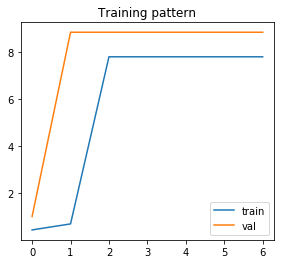

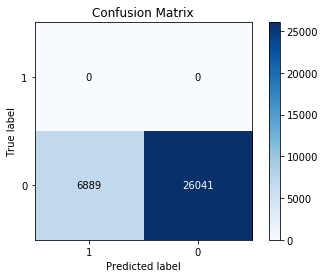

For Test year 1999
F1 Score 0.4430270796684738


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2 Score 0.4146766705696267
F1_w Score 0.8860541593369476


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2_w Score 0.4146766705696267
Precision 1.0
Precision_w 1.0
Recall 0.3977097121748499


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall_w 0.7954194243496998


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC Score 0.0


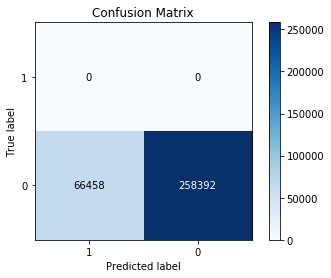

No. of Fires in Train set are 294
No. of Fire sequences in Train set are 2167
No. of no-fire sequences in Train set are 648591
No. of Fires in Test set are 0
No. of Fire sequences in Test set are 0
No. of no-fire sequences in Test set are 32919
Fires in Test are []
{0: 0.5017161836270223, 1: 146.1720575022462}
Train on 585682 samples, validate on 65076 samples
Epoch 1/25
 - 102s - loss: 0.5273 - val_loss: 0.5897
Epoch 2/25
 - 98s - loss: 6.2695 - val_loss: 8.4723
Epoch 3/25
 - 97s - loss: 7.8263 - val_loss: 8.4723
Epoch 4/25
 - 98s - loss: 7.8263 - val_loss: 8.4723
Epoch 5/25
 - 100s - loss: 7.8263 - val_loss: 8.4723
Epoch 6/25
 - 95s - loss: 7.8263 - val_loss: 8.4723
Epoch 7/25
 - 97s - loss: 7.8263 - val_loss: 8.4723
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


****Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 150};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.4428912318705681;and received F2_Score:	0.4144862714291145;and MCC_Score:	0.0;of CM	[[    0     0] [ 6749 26170]];



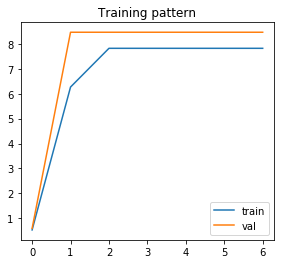

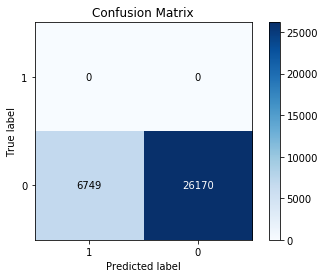

For Test year 2000
F1 Score 0.45140097041432076


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2 Score 0.426526444840091
F1_w Score 0.9028019408286415


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2_w Score 0.426526444840091
Precision 1.0
Precision_w 1.0
Recall 0.4114124762080187


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall_w 0.8228249524160374


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC Score 0.0


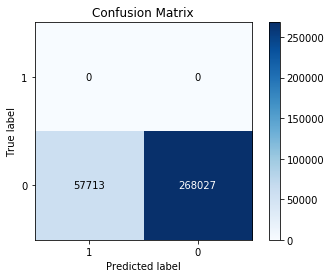

No. of Fires in Train set are 290
No. of Fire sequences in Train set are 2150
No. of no-fire sequences in Train set are 649476
No. of Fires in Test set are 4
No. of Fire sequences in Test set are 17
No. of no-fire sequences in Test set are 32034
Fires in Test are ['2001_ballinger', '2001_bell', '2001_jamacha', '2001_viejas']
{0: 0.501699983677693, 1: 147.56023550724638}
Train on 586463 samples, validate on 65163 samples
Epoch 1/25
 - 101s - loss: 0.8027 - val_loss: 7.5405
Epoch 2/25
 - 102s - loss: 0.9471 - val_loss: 0.5027
Epoch 3/25
 - 100s - loss: 0.3642 - val_loss: 0.5005
Epoch 4/25
 - 102s - loss: 0.3615 - val_loss: 0.5511
Epoch 5/25
 - 104s - loss: 0.3582 - val_loss: 0.5099
Epoch 6/25
 - 103s - loss: 0.3206 - val_loss: 0.5047
Epoch 7/25
 - 112s - loss: 0.3193 - val_loss: 0.7828
Epoch 8/25
 - 101s - loss: 0.3064 - val_loss: 0.6207
Epoch 9/25
 - 103s - loss: 0.3079 - val_loss: 1.0505
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
****Building LST

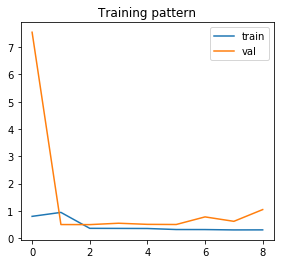

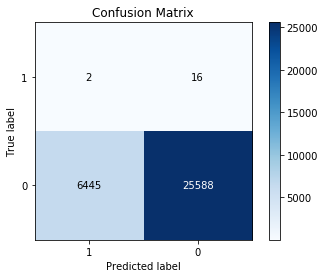

For Test year 2001
F1 Score 0.4442276645369168
F2 Score 0.4163914651996463
F1_w Score 0.8883781704557003
F2_w Score 0.4163914651996463
Precision 0.9998860510058135
Precision_w 0.9998860510058135
Recall 0.42905558168260577
Recall_w 0.799248884100354
MCC Score -0.002562638184086827


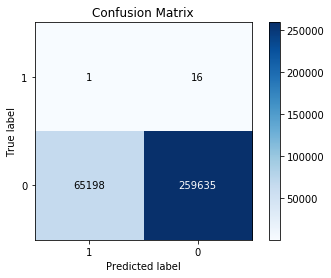

Missed warning about fire bell
	Warned about fire jamacha
Missed warning about fire viejas
	Warned about fire ballinger
32.56666666666667 -116.64166663333334 Missed Fire bell
32.56666666666667 -116.59999996666667 Missed Fire bell
32.608333333333334 -116.64166663333334 Missed Fire bell
32.608333333333334 -116.59999996666667 Missed Fire bell
32.733333333333334 -116.97499996666667 Missed Fire jamacha
32.733333333333334 -116.84999996666667 Missed Fire viejas
32.733333333333334 -116.80833330000002 Missed Fire viejas
32.733333333333334 -116.76666663333334 Missed Fire viejas
32.775000000000006 -116.84999996666667 Missed Fire viejas
32.775000000000006 -116.80833330000002 Missed Fire viejas
32.775000000000006 -116.76666663333334 Missed Fire viejas
32.775000000000006 -116.72499996666667 Missed Fire viejas
32.775000000000006 -116.68333330000002 Missed Fire viejas
32.81666666666667 -116.76666663333334 Missed Fire viejas
32.81666666666667 -116.72499996666667 Missed Fire viejas
32.81666666666667 -11

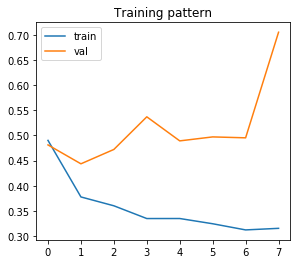

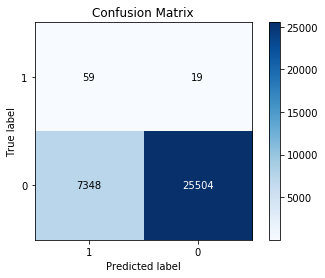

For Test year 2002
F1 Score 0.4303820032786893
F2 Score 0.39801706947477095
F1_w Score 0.8591447703522874
F2_w Score 0.39801706947477095
Precision 0.9996957486480622
Precision_w 0.9996957486480622
Recall 0.7567084904934185
Recall_w 0.7534185008465446
MCC Score 0.01809421749400072


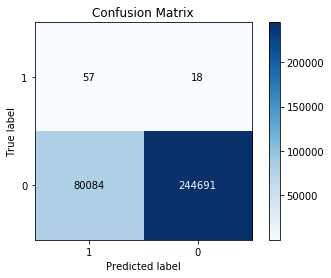

	Warned about fire border#4
	Warned about fire border#2
	Warned about fire bobcat
	Warned about fire manzanita#2
	Warned about fire troy
	Warned about fire wildcat
	Warned about fire canyon
	Warned about fire garnet
	Warned about fire pines
	Warned about fire peak
	Warned about fire woodland
	Warned about fire palm#1
	Warned about fire gavilan
Missed warning about fire nate
	Warned about fire mateo
	Warned about fire laguna
	Warned about fire avery
	Warned about fire antonio
32.56666666666667 -116.59999996666667 Missed Fire border#4
32.56666666666667 -116.55833330000002 Missed Fire border#4
32.858333333333334 -116.93333330000002 Missed Fire wildcat
32.858333333333334 -116.89166663333334 Missed Fire wildcat
33.275000000000006 -116.47499996666667 Missed Fire palm#1
33.275000000000006 -116.47499996666667 Missed Fire pines
33.31666666666667 -117.30833330000002 Missed Fire gavilan
33.31666666666667 -116.97499996666667 Missed Fire nate
33.31666666666667 -116.51666663333334 Missed Fire pines


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


****Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 150};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.49863866808537277;and received F2_Score:	0.49945457623080836;and MCC_Score:	0.0;of CM	[[    0   174] [    0 31867]];



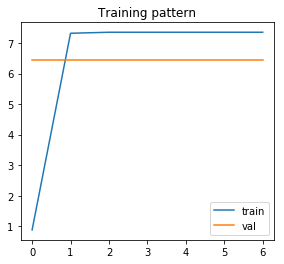

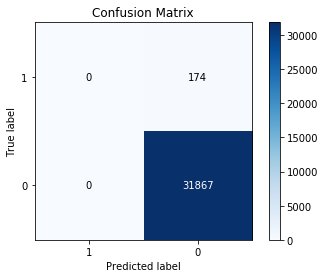

For Test year 2003
F1 Score 0.4998660561701918


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F2 Score 0.49994641385503663
F1_w Score 0.9991966239994656


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F2_w Score 0.49994641385503663
Precision 0.9989290232413065


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision_w 0.9989290232413065
Recall 0.5
Recall_w 0.9994643681699246


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC Score 0.0


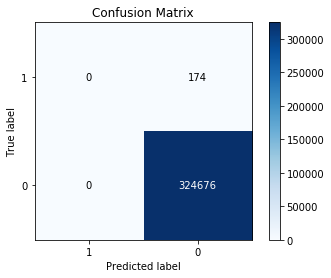

Missed warning about fire mine/otay
Missed warning about fire border#2
Missed warning about fire border#5
Missed warning about fire jewell
Missed warning about fire range
Missed warning about fire cedar
Missed warning about fire dehesa
Missed warning about fire dunbar
Missed warning about fire sycamore
Missed warning about fire paradise
Missed warning about fire grade
Missed warning about fire coyote
Missed warning about fire roblar 2
Missed warning about fire mountain
32.525000000000006 -116.93333330000002 Missed Fire mine/otay
32.525000000000006 -116.89166663333334 Missed Fire mine/otay
32.525000000000006 -116.84999996666667 Missed Fire mine/otay
32.525000000000006 -116.80833330000002 Missed Fire mine/otay
32.525000000000006 -116.76666663333334 Missed Fire mine/otay
32.56666666666667 -116.93333330000002 Missed Fire border#2
32.56666666666667 -116.93333330000002 Missed Fire border#5
32.56666666666667 -116.93333330000002 Missed Fire mine/otay
32.56666666666667 -116.89166663333334 Misse

33.19166666666667 -117.05833330000002 Missed Fire paradise
33.19166666666667 -117.01666663333334 Missed Fire paradise
33.19166666666667 -116.97499996666667 Missed Fire paradise
33.19166666666667 -116.93333330000002 Missed Fire paradise
33.19166666666667 -116.89166663333334 Missed Fire paradise
33.19166666666667 -116.84999996666667 Missed Fire paradise
33.19166666666667 -116.80833330000002 Missed Fire paradise
33.233333333333334 -117.01666663333334 Missed Fire paradise
33.233333333333334 -116.97499996666667 Missed Fire paradise
33.233333333333334 -116.93333330000002 Missed Fire paradise
33.233333333333334 -116.89166663333334 Missed Fire paradise
33.233333333333334 -116.84999996666667 Missed Fire paradise
33.233333333333334 -116.80833330000002 Missed Fire paradise
33.275000000000006 -117.01666663333334 Missed Fire paradise
33.275000000000006 -116.97499996666667 Missed Fire paradise
33.31666666666667 -116.64166663333334 Missed Fire coyote
33.31666666666667 -116.59999996666667 Missed Fire 

In [27]:
for test_year in range(1999,2004,1):
    X_train,y_train,X_test,y_test = train_test_partition(test_year)
    #Normalize the train datset
    X_train_norm = []
    for seq in X_train:
        seq[:,18] = 0
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_train_norm.append(temp)

    #Normalize the train datset
    X_test_norm = []
    for seq in X_test:
        seq[:,18] = 0
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_test_norm.append(temp)

    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    class_weight1 = dict(enumerate(temp))
    print (class_weight1)

    train_model(X_train_norm,X_test_norm,y_train,y_test,10,10,10,0.1,{0:0.5,1:150},'binary_crossentropy',0,0,lag)
    test_model(df_sorted,scaler,test_year)

No. of Fires in Train set are 265
No. of Fire sequences in Train set are 2114
No. of no-fire sequences in Train set are 648633
No. of Fires in Test set are 29
No. of Fire sequences in Test set are 53
No. of no-fire sequences in Test set are 32877
Fires in Test are ['2004_antonio', '2004_bandy', '2004_border #10', '2004_border #16', '2004_border #7', '2004_border 14', '2004_camino', '2004_cary', '2004_cole grade', '2004_eagle', '2004_el moro', '2004_emerald', '2004_hi pass', '2004_la posta', '2004_lost', '2004_lucky', '2004_mataguay', '2004_melton', '2004_morales', '2004_morena', '2004_ornales', '2004_ortega', '2004_pauma', '2004_pleasure', '2004_school', '2004_scissors', '2004_sheephead', '2004_trinity', '2004_warner']
{0: 0.5016682521743555, 1: 150.35743992606285}
Train on 585672 samples, validate on 65075 samples
Epoch 1/25
 - 108s - loss: 0.6541 - val_loss: 0.5061
Epoch 2/25
 - 101s - loss: 0.4189 - val_loss: 0.9275
Epoch 3/25
 - 97s - loss: 3.2741 - val_loss: 8.0470
Epoch 4/25
 - 1

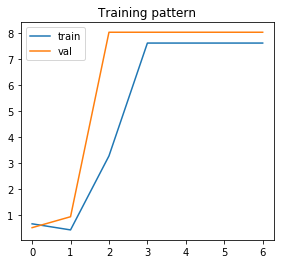

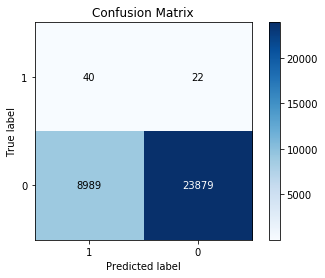

For Test year 2004
F1 Score 0.41458923660853936
F2 Score 0.37646979961959803
F1_w Score 0.8283522153960041
F2_w Score 0.37646979961959803
Precision 0.9997505425837575
Precision_w 0.9997505425837575
Recall 0.664939413122137
Recall_w 0.7072235525265549
MCC Score 0.00924608167308183


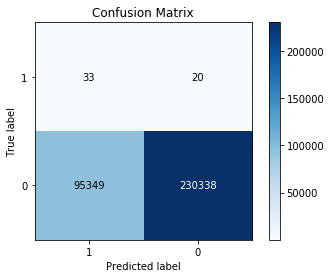

	Warned about fire border 14
	Warned about fire border #16
	Warned about fire border #7
	Warned about fire morena
	Warned about fire la posta
	Warned about fire border #10
	Warned about fire hi pass
	Warned about fire sheephead
	Warned about fire lucky
	Warned about fire camino
	Warned about fire bandy
	Warned about fire scissors
	Warned about fire emerald
	Warned about fire mataguay
	Warned about fire ornales
	Warned about fire cole grade
	Warned about fire pauma
	Warned about fire lost
	Warned about fire warner
	Warned about fire eagle
	Warned about fire morales
	Warned about fire school
	Warned about fire pleasure
	Warned about fire ortega
	Warned about fire cary
Missed warning about fire el moro
	Warned about fire antonio
	Warned about fire melton
	Warned about fire trinity
33.150000000000006 -117.14166663333334 Missed Fire emerald
33.275000000000006 -117.05833330000002 Missed Fire cole grade
33.483333333333334 -116.89166663333334 Missed Fire pleasure
33.483333333333334 -116.849999

In [25]:
train_n_test_model(2004)

No. of Fires in Train set are 258
No. of Fire sequences in Train set are 2110
No. of no-fire sequences in Train set are 649523
No. of Fires in Test set are 36
No. of Fire sequences in Test set are 57
No. of no-fire sequences in Test set are 31987
Fires in Test are ['2005_barrett', '2005_beauty', '2005_bella', '2005_border#1', '2005_border#20', '2005_border#26', '2005_border#31', '2005_border#33', '2005_border#40', '2005_border#44', '2005_border#48', '2005_border#49', '2005_border#50', '2005_border#6', '2005_border#7', '2005_borel', '2005_church', '2005_hauser', '2005_hwy 94', '2005_magee', '2005_mazzetti', '2005_miller', '2005_mission', '2005_pauma', '2005_proctor', '2005_railroad', '2005_ribbonwood', '2005_ridge', '2005_rincon#11', '2005_rincon#15', '2005_rock', '2005_sand', '2005_skye', '2005_spice', '2005_summitt', '2005_volcan']
{0: 0.5016667487851596, 1: 150.49260969976905}
Train on 586469 samples, validate on 65164 samples
Epoch 1/25
 - 110s - loss: 0.4604 - val_loss: 0.5455
Epoc

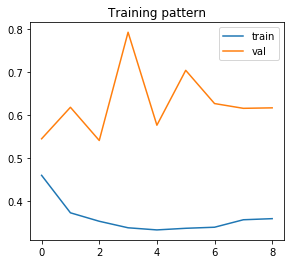

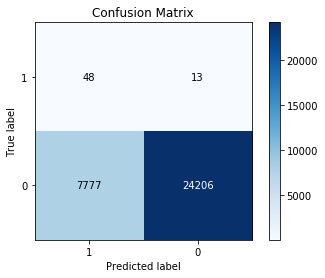

For Test year 2005
F1 Score 0.4307904582025423
F2 Score 0.39839146649942847
F1_w Score 0.8603249736508393
F2_w Score 0.39839146649942847
Precision 0.9997716400755712
Precision_w 0.9997716400755712
Recall 0.7635392442398264
Recall_w 0.7551516084346621
MCC Score 0.016233430358034054


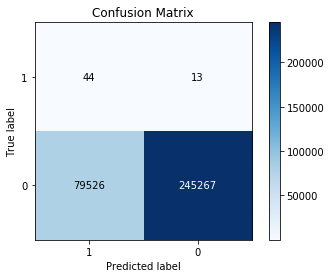

Missed warning about fire border#1
	Warned about fire border#20
	Warned about fire border#31
	Warned about fire border#33
	Warned about fire border#50
	Warned about fire border#44
	Warned about fire border#7
	Warned about fire border#40
	Warned about fire border#48
	Warned about fire border#49
	Warned about fire border#26
	Warned about fire border#6
Missed warning about fire hwy 94
	Warned about fire church
	Warned about fire railroad
	Warned about fire proctor
	Warned about fire spice
	Warned about fire hauser
	Warned about fire barrett
	Warned about fire sand
	Warned about fire ribbonwood
	Warned about fire summitt
	Warned about fire skye
	Warned about fire miller
	Warned about fire ridge
	Warned about fire volcan
	Warned about fire mission
	Warned about fire mazzetti
	Warned about fire rincon#11
	Warned about fire rincon#15
	Warned about fire pauma
	Warned about fire magee
	Warned about fire beauty
	Warned about fire rock
	Warned about fire bella
	Warned about fire borel
32.52500000

In [27]:
train_n_test_model(2005)

No. of Fires in Train set are 274
No. of Fire sequences in Train set are 2094
No. of no-fire sequences in Train set are 648622
No. of Fires in Test set are 20
No. of Fire sequences in Test set are 73
No. of no-fire sequences in Test set are 32888
Fires in Test are ['2006_67', '2006_angel', '2006_bonny', '2006_border 15', '2006_border 16', '2006_border 30', '2006_camino', '2006_campo', '2006_castle', '2006_cottonwood', '2006_deluz', '2006_felipe', '2006_gunn 2', '2006_horse', '2006_horse fire', '2006_lilac', '2006_open', '2006_pala', '2006_pine', '2006_proctor']
{0: 0.5016466742730272, 1: 152.32116104868913}
Train on 585644 samples, validate on 65072 samples
Epoch 1/25
 - 100s - loss: 0.4553 - val_loss: 0.9636
Epoch 2/25
 - 107s - loss: 0.3687 - val_loss: 0.4967
Epoch 3/25
 - 97s - loss: 0.3751 - val_loss: 0.7163
Epoch 4/25
 - 93s - loss: 0.4165 - val_loss: 0.5346
Epoch 5/25
 - 94s - loss: 0.3824 - val_loss: 0.5267
Epoch 6/25
 - 101s - loss: 0.3969 - val_loss: 0.5997
Epoch 7/25
 - 92s -

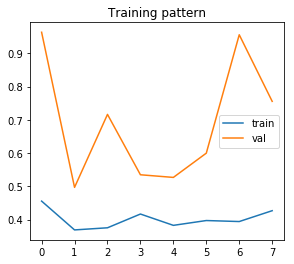

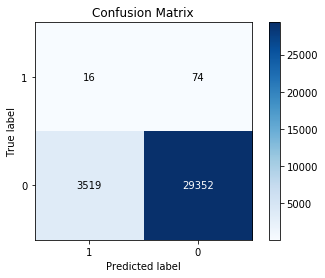

For Test year 2006
F1 Score 0.47564252907947857
F2 Score 0.462507492280062
F1_w Score 0.950417664812334
F2_w Score 0.462507492280062
Precision 0.9995613630055886
Precision_w 0.9995613630055886
Recall 0.5215347761694948
Recall_w 0.9059104201939356
MCC Score 0.002212921027975543


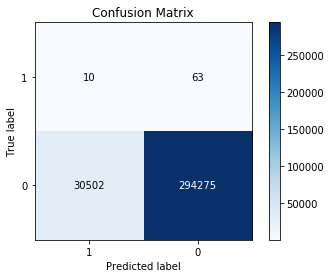

	Warned about fire border 30
	Warned about fire border 15
	Warned about fire border 16
	Warned about fire campo
Missed warning about fire gunn 2
Missed warning about fire proctor
	Warned about fire horse
	Warned about fire horse fire
Missed warning about fire cottonwood
	Warned about fire pine
	Warned about fire 67
	Warned about fire open
Missed warning about fire angel
	Warned about fire felipe
	Warned about fire camino
	Warned about fire castle
	Warned about fire pala
	Warned about fire lilac
	Warned about fire deluz
	Warned about fire bonny
32.56666666666667 -116.64166663333334 Missed Fire border 15
32.608333333333334 -116.47499996666667 Missed Fire campo
32.608333333333334 -116.18333330000002 Missed Fire gunn 2
32.608333333333334 -116.14166663333334 Missed Fire gunn 2
32.650000000000006 -116.93333330000002 Missed Fire proctor
32.650000000000006 -116.68333330000002 Missed Fire horse
32.650000000000006 -116.64166663333334 Missed Fire horse
32.650000000000006 -116.59999996666667 Misse

In [26]:
train_n_test_model(2006)

No. of Fires in Train set are 265
No. of Fire sequences in Train set are 1090
No. of no-fire sequences in Train set are 649845
No. of Fires in Test set are 29
No. of Fire sequences in Test set are 1077
No. of no-fire sequences in Test set are 31665
Fires in Test are ['2007_78-4', '2007_ammo', '2007_angel', '2007_angel 3', '2007_antonio', '2007_banner', '2007_barrett', '2007_border 25', '2007_border 26', '2007_border 34', '2007_border26', '2007_colina', '2007_coronado hills', '2007_crown valley', '2007_harris', '2007_harris 2', '2007_hauser', '2007_inkopah', '2007_mccoy', '2007_millar', '2007_morena', '2007_pine', '2007_poomacha', '2007_rice', '2007_roca', '2007_rosa', '2007_unnamed', '2007_vuelta', '2007_witch']
{0: 0.5008841372390295, 1: 283.2615317667537}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 585841 samples, validate on 65094 samples
Epoch 1/25
 - 109s - loss: 0.4424 - val_loss: 0.3850
Epoch 2/25
 - 112s - loss: 0.3696 

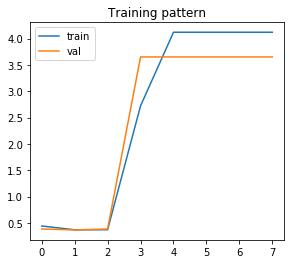

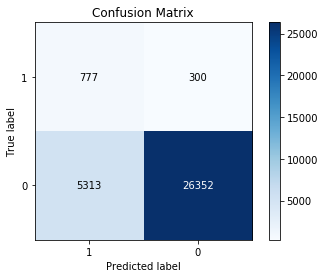

For Test year 2007
F1 Score 0.4685453553429285
F2 Score 0.4643462793257568
F1_w Score 0.9061955992887686
F2_w Score 0.4643462793257568
Precision 0.995626020890021
Precision_w 0.995626020890021
Recall 0.7777988510761267
Recall_w 0.8337755887332615
MCC Score 0.08548830800330463


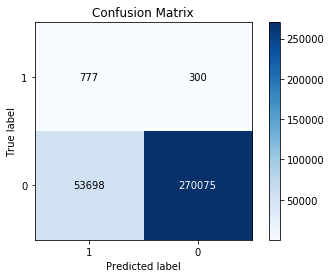

	Warned about fire harris
	Warned about fire harris 2
	Warned about fire border 26
	Warned about fire border26
	Warned about fire border 34
	Warned about fire border 25
	Warned about fire barrett
	Warned about fire inkopah
	Warned about fire hauser
	Warned about fire morena
	Warned about fire millar
	Warned about fire pine
	Warned about fire witch
	Warned about fire mccoy
	Warned about fire 78-4
	Warned about fire angel 3
	Warned about fire angel
	Warned about fire banner
	Warned about fire coronado hills
	Warned about fire poomacha
	Warned about fire ammo
	Warned about fire vuelta
	Warned about fire rice
	Warned about fire roca
	Warned about fire colina
	Warned about fire rosa
	Warned about fire antonio
	Warned about fire crown valley
Missed warning about fire unnamed
32.525000000000006 -116.80833330000002 Missed Fire harris 2
32.525000000000006 -116.76666663333334 Missed Fire harris 2
32.525000000000006 -116.76666663333334 Missed Fire harris
32.56666666666667 -116.93333330000002 Miss

33.108333333333334 -117.18333330000002 Missed Fire coronado hills
33.108333333333334 -117.05833330000002 Missed Fire witch
33.108333333333334 -117.01666663333334 Missed Fire witch
33.108333333333334 -116.97499996666667 Missed Fire witch
33.108333333333334 -116.93333330000002 Missed Fire witch
33.108333333333334 -116.89166663333334 Missed Fire witch
33.108333333333334 -116.84999996666667 Missed Fire witch
33.108333333333334 -116.80833330000002 Missed Fire witch
33.108333333333334 -116.76666663333334 Missed Fire witch
33.108333333333334 -116.72499996666667 Missed Fire witch
33.150000000000006 -117.05833330000002 Missed Fire witch
33.150000000000006 -117.01666663333334 Missed Fire witch
33.150000000000006 -116.97499996666667 Missed Fire witch
33.150000000000006 -116.93333330000002 Missed Fire witch
33.150000000000006 -116.89166663333334 Missed Fire witch
33.150000000000006 -116.84999996666667 Missed Fire witch
33.150000000000006 -116.80833330000002 Missed Fire witch
33.150000000000006 -11

In [24]:
train_n_test_model(2007)

No. of Fires in Train set are 283
No. of Fire sequences in Train set are 2139
No. of no-fire sequences in Train set are 648607
No. of Fires in Test set are 11
No. of Fire sequences in Test set are 28
No. of no-fire sequences in Test set are 32903
Fires in Test are ['2008_benton', '2008_border 6', '2008_border no. 14', '2008_carrizo', '2008_harbison', '2008_monte', '2008_mountain', '2008_shockey', '2008_vail', '2008_valley', '2008_yankee']
{0: 0.5016930074782207, 1: 148.16621129326046}
Train on 585671 samples, validate on 65075 samples
Epoch 1/25
 - 130s - loss: 0.5257 - val_loss: 0.5425
Epoch 2/25
 - 122s - loss: 0.4435 - val_loss: 0.6383
Epoch 3/25
 - 133s - loss: 5.8363 - val_loss: 6.9126
Epoch 4/25
 - 136s - loss: 7.8816 - val_loss: 6.9126
Epoch 5/25
 - 145s - loss: 7.8816 - val_loss: 6.9126
Epoch 6/25
 - 129s - loss: 7.8816 - val_loss: 6.9126
Epoch 7/25
 - 112s - loss: 7.8816 - val_loss: 6.9126
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
****B

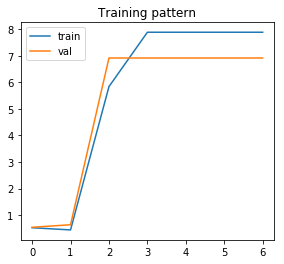

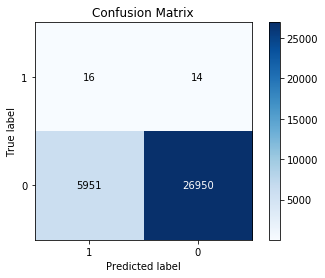

For Test year 2008
F1 Score 0.4435424944768128
F2 Score 0.4156571774374152
F1_w Score 0.8865567553772497
F2_w Score 0.4156571774374152
Precision 0.9998639509334001
Precision_w 0.9998639509334001
Recall 0.6660494108730588
Recall_w 0.7963621293055811
MCC Score 0.007645443653808153


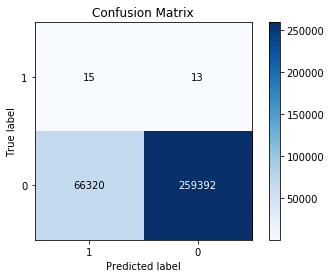

	Warned about fire border 6
	Warned about fire border no. 14
	Warned about fire shockey
	Warned about fire mountain
	Warned about fire carrizo
	Warned about fire harbison
	Warned about fire monte
	Warned about fire yankee
	Warned about fire vail
	Warned about fire valley
	Warned about fire benton
32.525000000000006 -116.89166663333334 Missed Fire border 6
32.525000000000006 -116.84999996666667 Missed Fire border no. 14
32.525000000000006 -116.80833330000002 Missed Fire border no. 14
32.733333333333334 -116.26666663333334 Missed Fire carrizo
32.733333333333334 -116.22499996666667 Missed Fire carrizo
32.775000000000006 -116.84999996666667 Missed Fire harbison
32.858333333333334 -116.89166663333334 Missed Fire monte


In [29]:
train_n_test_model(2008)

No. of Fires in Train set are 284
No. of Fire sequences in Train set are 2152
No. of no-fire sequences in Train set are 649484
No. of Fires in Test set are 10
No. of Fire sequences in Test set are 15
No. of no-fire sequences in Test set are 32026
Fires in Test are ['2009_checkpoint', '2009_de luz', '2009_grande ic', '2009_ortega', '2009_ortega 2', '2009_ortega 3', '2009_pala 4', '2009_san juan', '2009_vail', '2009_willow 3']
{0: 0.5017022750895023, 1: 147.36227951153325}
Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 108s - loss: 0.4553 - val_loss: 0.4927
Epoch 2/25
 - 105s - loss: 0.3796 - val_loss: 0.6167
Epoch 3/25
 - 108s - loss: 0.3438 - val_loss: 0.5921
Epoch 4/25
 - 115s - loss: 0.3443 - val_loss: 0.5797
Epoch 5/25
 - 116s - loss: 7.3032 - val_loss: 7.2572
Epoch 6/25
 - 111s - loss: 7.8905 - val_loss: 7.2572
Epoch 7/25
 - 103s - loss: 7.8905 - val_loss: 7.2572
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
****Building LSTM o

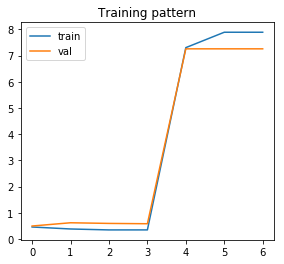

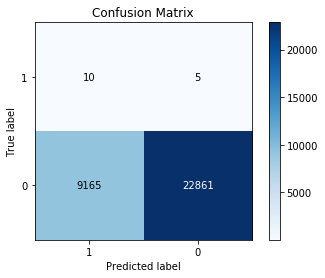

For Test year 2009
F1 Score 0.40752050485573094
F2 Score 0.36693534286106066
F1_w Score 0.8148063858012219
F2_w Score 0.36693534286106066
Precision 0.9999314436350429
Precision_w 0.9999314436350429
Recall 0.6771094042616508
Recall_w 0.6875511774665231
MCC Score 0.005192995999104712


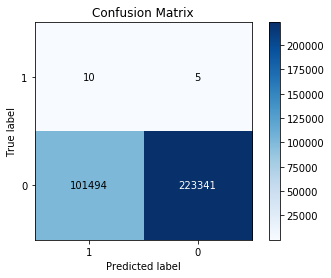

	Warned about fire checkpoint
	Warned about fire willow 3
	Warned about fire ortega 2
	Warned about fire pala 4
Missed warning about fire grande ic
	Warned about fire vail
	Warned about fire ortega
	Warned about fire de luz
	Warned about fire san juan
	Warned about fire ortega 3
33.31666666666667 -117.34999996666667 Missed Fire ortega 2
33.31666666666667 -117.14166663333334 Missed Fire pala 4
33.44166666666667 -117.34999996666667 Missed Fire grande ic
33.483333333333334 -117.34999996666667 Missed Fire grande ic


In [27]:
train_n_test_model(2009)

No. of Fires in Train set are 278
No. of Fire sequences in Train set are 2136
No. of no-fire sequences in Train set are 648604
No. of Fires in Test set are 16
No. of Fire sequences in Test set are 31
No. of no-fire sequences in Test set are 32906
Fires in Test are ['2010_76-2', '2010_border 10', '2010_border 12', '2010_clinton', '2010_cowboy', '2010_felipe', '2010_mesa', '2010_minto', '2010_monte', '2010_narrows', '2010_pala 5', '2010_rock', '2010_santa', '2010_slaughterhouse', '2010_tenaja', '2010_tenaja 2']
{0: 0.5016891553298208, 1: 148.50296668188042}
Train on 585666 samples, validate on 65074 samples
Epoch 1/25
 - 97s - loss: 0.4980 - val_loss: 0.4455
Epoch 2/25
 - 116s - loss: 1.5311 - val_loss: 6.6291
Epoch 3/25
 - 101s - loss: 7.8935 - val_loss: 6.6291
Epoch 4/25
 - 107s - loss: 7.8935 - val_loss: 6.6291
Epoch 5/25
 - 107s - loss: 7.8935 - val_loss: 6.6291
Epoch 6/25
 - 107s - loss: 7.8935 - val_loss: 6.6291
Epoch 7/25
 - 106s - loss: 7.8935 - val_loss: 6.6291
Restoring model w

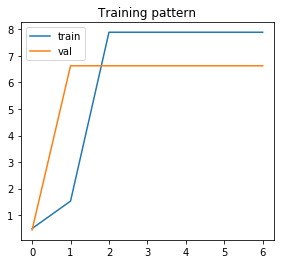

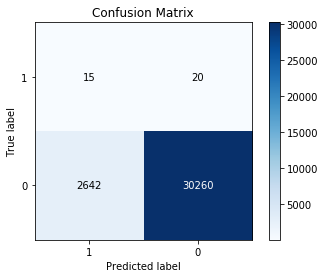

For Test year 2010
F1 Score 0.4749921313092682
F2 Score 0.461545921655694
F1_w Score 0.9491299079943559
F2_w Score 0.461545921655694
Precision 0.9998398694527566
Precision_w 0.9998398694527566
Recall 0.6452491804616943
Recall_w 0.9033523164537479
MCC Score 0.009604644817255197


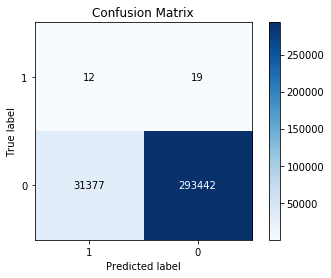

Missed warning about fire border 12
	Warned about fire border 10
	Warned about fire cowboy
	Warned about fire monte
	Warned about fire slaughterhouse
	Warned about fire mesa
	Warned about fire narrows
	Warned about fire felipe
	Warned about fire santa
	Warned about fire 76-2
	Warned about fire pala 5
Missed warning about fire tenaja 2
	Warned about fire minto
	Warned about fire clinton
Missed warning about fire tenaja
	Warned about fire rock
32.56666666666667 -116.59999996666667 Missed Fire border 12
32.56666666666667 -116.34999996666667 Missed Fire border 10
32.56666666666667 -116.30833330000002 Missed Fire border 10
32.900000000000006 -116.97499996666667 Missed Fire slaughterhouse
33.06666666666667 -116.47499996666667 Missed Fire narrows
33.108333333333334 -116.47499996666667 Missed Fire narrows
33.275000000000006 -117.26666663333334 Missed Fire 76-2
33.358333333333334 -117.05833330000002 Missed Fire pala 5
33.483333333333334 -117.39166663333334 Missed Fire tenaja 2
33.56666666666667

In [26]:
train_n_test_model(2010)

No. of Fires in Train set are 280
No. of Fire sequences in Train set are 2084
No. of no-fire sequences in Train set are 649511
No. of Fires in Test set are 14
No. of Fire sequences in Test set are 83
No. of no-fire sequences in Test set are 31999
Fires in Test are ['2011_barrett', '2011_bee', '2011_border 12', '2011_border 16', '2011_canyon', '2011_eagle', '2011_granite', '2011_great', '2011_pala', '2011_pony', '2011_ridge', '2011_sage', '2011_theodore', '2011_wayman']
{0: 0.5016498524910232, 1: 152.0286980867942}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 586435 samples, validate on 65160 samples
Epoch 1/25
 - 102s - loss: 0.4879 - val_loss: 0.5116
Epoch 2/25
 - 107s - loss: 0.3973 - val_loss: 0.8832
Epoch 3/25
 - 102s - loss: 0.3750 - val_loss: 0.5460
Epoch 4/25
 - 109s - loss: 5.2941 - val_loss: 7.8595
Epoch 5/25
 - 101s - loss: 7.5568 - val_loss: 7.8595
Epoch 6/25
 - 101s - loss: 7.5567 - val_loss: 7.8595
Epoch 7/25
 - 97s

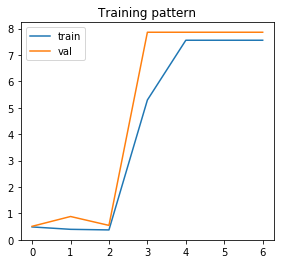

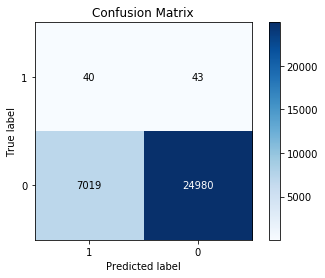

For Test year 2011
F1 Score 0.43617847119746583
F2 Score 0.4057831567615717
F1_w Score 0.8710559137272219
F2_w Score 0.4057831567615717
Precision 0.9995732066800759
Precision_w 0.9995732066800759
Recall 0.6269729019073211
Recall_w 0.7719439741419116
MCC Score 0.009673323052739598


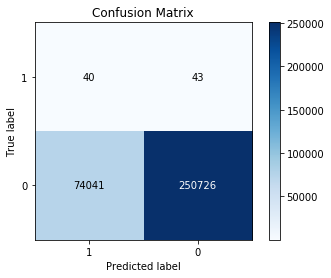

	Warned about fire bee
	Warned about fire border 16
	Warned about fire border 12
	Warned about fire barrett
	Warned about fire ridge
	Warned about fire great
	Warned about fire eagle
	Warned about fire pala
	Warned about fire sage
	Warned about fire canyon
	Warned about fire wayman
	Warned about fire pony
	Warned about fire granite
	Warned about fire theodore
32.56666666666667 -116.76666663333334 Missed Fire bee
32.608333333333334 -116.09999996666667 Missed Fire border 12
33.233333333333334 -116.51666663333334 Missed Fire eagle
33.233333333333334 -116.47499996666667 Missed Fire eagle
33.275000000000006 -116.55833330000002 Missed Fire eagle
33.275000000000006 -116.51666663333334 Missed Fire eagle
33.275000000000006 -116.47499996666667 Missed Fire eagle
33.31666666666667 -116.55833330000002 Missed Fire eagle
33.31666666666667 -116.51666663333334 Missed Fire eagle
33.358333333333334 -116.51666663333334 Missed Fire eagle
33.44166666666667 -116.64166663333334 Missed Fire canyon
33.441666666

In [24]:
train_n_test_model(2011)

No. of Fires in Train set are 266
No. of Fire sequences in Train set are 2019
No. of no-fire sequences in Train set are 648645
No. of Fires in Test set are 28
No. of Fire sequences in Test set are 148
No. of no-fire sequences in Test set are 32865
Fires in Test are ['2012_banner', '2012_banner fire', '2012_bonita', '2012_border 12', '2012_border 6', '2012_border 7', '2012_bradford', '2012_buck', '2012_buckman 2', '2012_cary', '2012_chihauhau 2', '2012_chihuahua 2', '2012_cottonwood', '2012_dulzura', '2012_la posta', '2012_marron', '2012_martinez', '2012_old', '2012_old - 2', '2012_rock', '2012_shockey', '2012_shoots', '2012_stweart', '2012_vallecito', '2012_vallecito lightning complex', '2012_volcano', '2012_wilson', '2012_wynola']
{0: 0.501601173011485, 1: 156.63553201733268}
Train on 585597 samples, validate on 65067 samples
Epoch 1/25
 - 101s - loss: 0.4602 - val_loss: 0.4927
Epoch 2/25
 - 95s - loss: 0.4078 - val_loss: 0.5908
Epoch 3/25
 - 113s - loss: 0.4044 - val_loss: 0.4909
Epo

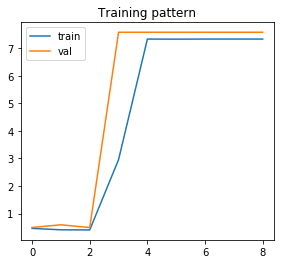

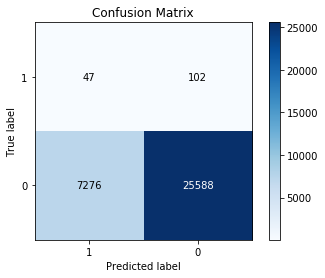

For Test year 2012
F1 Score 0.447086314028816
F2 Score 0.42125293949822223
F1_w Score 0.8923120792709865
F2_w Score 0.42125293949822223
Precision 0.9991578585324086
Precision_w 0.9991578585324086
Recall 0.5586431999458118
Recall_w 0.8062503837416344
MCC Score 0.006326089866128554


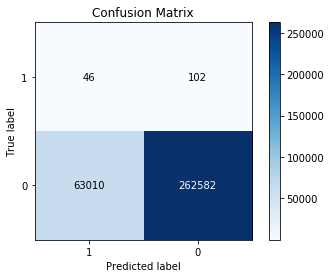

	Warned about fire border 6
	Warned about fire border 7
	Warned about fire shockey
	Warned about fire border 12
	Warned about fire dulzura
	Warned about fire marron
	Warned about fire old - 2
	Warned about fire old
	Warned about fire la posta
	Warned about fire buckman 2
	Warned about fire vallecito
	Warned about fire vallecito lightning complex
	Warned about fire banner fire
	Warned about fire banner
	Warned about fire wynola
	Warned about fire stweart
	Warned about fire wilson
	Warned about fire cottonwood
	Warned about fire chihauhau 2
	Warned about fire chihuahua 2
	Warned about fire shoots
	Warned about fire bradford
	Warned about fire volcano
	Warned about fire buck
	Warned about fire rock
	Warned about fire martinez
	Warned about fire cary
	Warned about fire bonita
32.525000000000006 -116.89166663333334 Missed Fire border 6
32.56666666666667 -116.26666663333334 Missed Fire border 6
32.608333333333334 -116.26666663333334 Missed Fire border 6
32.650000000000006 -116.39166663333334

In [25]:
train_n_test_model(2012)

No. of Fires in Train set are 276
No. of Fire sequences in Train set are 2079
No. of no-fire sequences in Train set are 649509
No. of Fires in Test set are 18
No. of Fire sequences in Test set are 88
No. of no-fire sequences in Test set are 32001
Fires in Test are ['2013_boden', '2013_border', '2013_border2', '2013_chariot', '2013_deluz', '2013_felipe', '2013_general', '2013_la posta', '2013_la posta 2', '2013_lyon', '2013_miguel', '2013_morena', '2013_otay', '2013_peutz', '2013_red', '2013_thomas', '2013_vail', '2013_valley 2']
{0: 0.5016398289034857, 1: 152.95492957746478}
Train on 586429 samples, validate on 65159 samples
Epoch 1/25
 - 130s - loss: 0.4685 - val_loss: 0.5457
Epoch 2/25
 - 121s - loss: 3.5847 - val_loss: 7.8242
Epoch 3/25
 - 130s - loss: 7.5095 - val_loss: 7.8242
Epoch 4/25
 - 111s - loss: 7.5095 - val_loss: 7.8242
Epoch 5/25
 - 100s - loss: 7.5095 - val_loss: 7.8242
Epoch 6/25
 - 102s - loss: 7.5095 - val_loss: 7.8242
Epoch 7/25
 - 96s - loss: 7.5095 - val_loss: 7.82

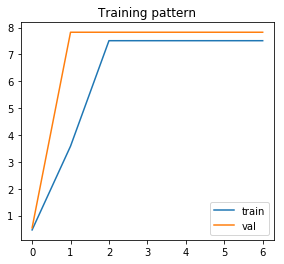

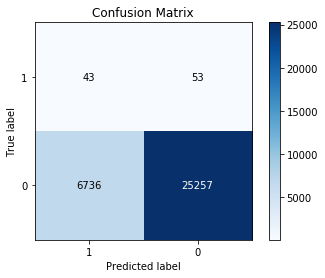

For Test year 2013
F1 Score 0.4266820425010825
F2 Score 0.3927600728206333
F1_w Score 0.8521768144542493
F2_w Score 0.3927600728206333
Precision 0.9995303750737458
Precision_w 0.9995303750737458
Recall 0.5987170464972671
Recall_w 0.7428105279359705
MCC Score 0.0074338054907070635


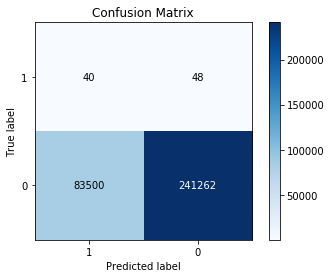

	Warned about fire border2
	Warned about fire otay
	Warned about fire border
	Warned about fire morena
	Warned about fire miguel
	Warned about fire lyon
	Warned about fire la posta 2
	Warned about fire la posta
	Warned about fire valley 2
	Warned about fire peutz
	Warned about fire chariot
	Warned about fire general
	Warned about fire boden
	Warned about fire felipe
	Warned about fire red
	Warned about fire deluz
Missed warning about fire vail
	Warned about fire thomas
32.525000000000006 -116.89166663333334 Missed Fire border2
32.56666666666667 -116.97499996666667 Missed Fire otay
32.56666666666667 -116.93333330000002 Missed Fire otay
32.56666666666667 -116.89166663333334 Missed Fire border2
32.56666666666667 -116.26666663333334 Missed Fire border
32.608333333333334 -116.26666663333334 Missed Fire border
32.650000000000006 -117.01666663333334 Missed Fire miguel
32.650000000000006 -116.97499996666667 Missed Fire miguel
32.733333333333334 -116.47499996666667 Missed Fire la posta 2
32.733

In [26]:
train_n_test_model(2013)

No. of Fires in Train set are 274
No. of Fire sequences in Train set are 2033
No. of no-fire sequences in Train set are 648633
No. of Fires in Test set are 20
No. of Fire sequences in Test set are 134
No. of no-fire sequences in Test set are 32877
Fires in Test are ['2014_aurora', '2014_banner', '2014_basilone complex', '2014_bernardo', '2014_border_8', '2014_cocos', '2014_combat-basilone complex', '2014_gun', '2014_highway', '2014_jacumba', '2014_poinsettia', '2014_pulgas-basilone complex', '2014_river', '2014_sabina', '2014_san diego complex', '2014_santa', '2014_tomahawk', '2014_tomahawk- basilone complex', '2014_viewpoint', '2014_wildcat_4']
{0: 0.5016127689361584, 1: 155.51290630975143}
Train on 585599 samples, validate on 65067 samples
Epoch 1/25
 - 111s - loss: 0.4604 - val_loss: 0.5566
Epoch 2/25
 - 102s - loss: 0.3706 - val_loss: 0.5115
Epoch 3/25
 - 103s - loss: 0.3417 - val_loss: 0.7015
Epoch 4/25
 - 123s - loss: 2.3783 - val_loss: 6.7007
Epoch 5/25
 - 124s - loss: 7.4965 - 

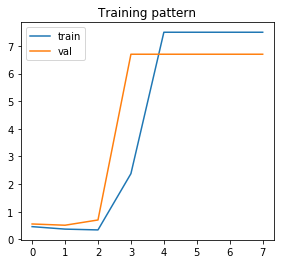

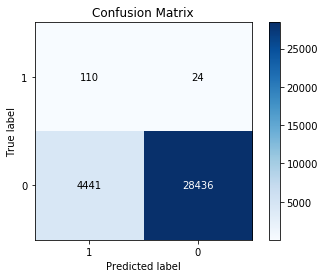

For Test year 2014
F1 Score 0.4748744670322331
F2 Score 0.46404506775882187
F1_w Score 0.9430725059423808
F2_w Score 0.46404506775882187
Precision 0.9995060817019062
Precision_w 0.9995060817019062
Recall 0.8569656414339935
Recall_w 0.8930060027705095
MCC Score 0.046848818724530526


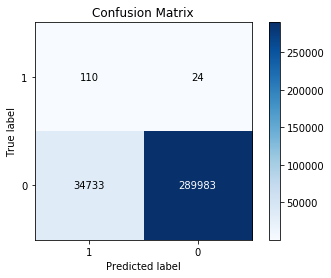

	Warned about fire border_8
	Warned about fire jacumba
Missed warning about fire gun
	Warned about fire aurora
	Warned about fire viewpoint
	Warned about fire wildcat_4
	Warned about fire bernardo
	Warned about fire poinsettia
	Warned about fire cocos
	Warned about fire san diego complex
	Warned about fire banner
	Warned about fire basilone complex
	Warned about fire pulgas-basilone complex
	Warned about fire river
	Warned about fire highway
	Warned about fire tomahawk
	Warned about fire tomahawk- basilone complex
	Warned about fire combat-basilone complex
	Warned about fire santa
	Warned about fire sabina
32.56666666666667 -116.93333330000002 Missed Fire border_8
32.650000000000006 -116.22499996666667 Missed Fire jacumba
32.775000000000006 -116.51666663333334 Missed Fire gun
32.81666666666667 -116.51666663333334 Missed Fire gun
32.94166666666667 -117.18333330000002 Missed Fire bernardo
32.983333333333334 -117.22499996666667 Missed Fire bernardo
32.983333333333334 -117.18333330000002 M

In [27]:
train_n_test_model(2014)

No. of Fires in Train set are 287
No. of Fire sequences in Train set are 2152
No. of no-fire sequences in Train set are 649482
No. of Fires in Test set are 7
No. of Fire sequences in Test set are 15
No. of no-fire sequences in Test set are 32028
Fires in Test are ['2015_anza', '2015_cutca', '2015_deluz', '2015_lake 3', '2015_mercado', '2015_park', '2015_wildcat']
{0: 0.501700735265812, 1: 147.49524671797192}
Train on 586470 samples, validate on 65164 samples
Epoch 1/25
 - 137s - loss: 0.5341 - val_loss: 0.6777
Epoch 2/25
 - 110s - loss: 0.4676 - val_loss: 0.5657
Epoch 3/25
 - 132s - loss: 5.9453 - val_loss: 7.6820
Epoch 4/25
 - 114s - loss: 7.8355 - val_loss: 7.6820
Epoch 5/25
 - 118s - loss: 7.8355 - val_loss: 7.6820
Epoch 6/25
 - 132s - loss: 7.8355 - val_loss: 7.6820
Epoch 7/25
 - 132s - loss: 7.8355 - val_loss: 7.6820
Epoch 8/25
 - 125s - loss: 7.8355 - val_loss: 7.6820
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
****Building LSTM of lag	10;wi

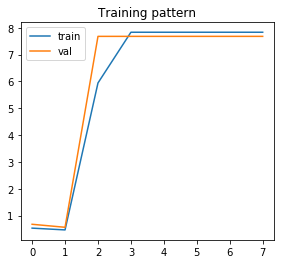

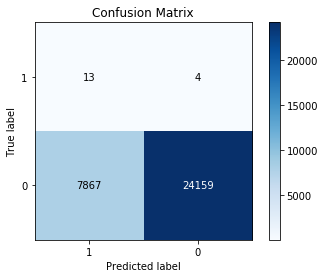

For Test year 2015
F1 Score 0.43446365427215466
F2 Score 0.4029539334784777
F1_w Score 0.8685956558334286
F2_w Score 0.4029539334784777
Precision 0.9999377943375378
Precision_w 0.9999377943375378
Recall 0.7505600279116064
Recall_w 0.7677851315991996
MCC Score 0.008064121006302384


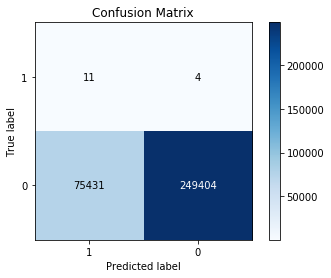

	Warned about fire park
	Warned about fire mercado
	Warned about fire wildcat
	Warned about fire lake 3
	Warned about fire cutca
	Warned about fire deluz
	Warned about fire anza
32.733333333333334 -116.97499996666667 Missed Fire mercado
32.94166666666667 -116.89166663333334 Missed Fire wildcat


In [28]:
train_n_test_model(2015)

No. of Fires in Train set are 290
No. of Fire sequences in Train set are 2120
No. of no-fire sequences in Train set are 648597
No. of Fires in Test set are 4
No. of Fire sequences in Test set are 47
No. of no-fire sequences in Test set are 32913
Fires in Test are ['2016_border 3', '2016_feather', '2016_pala', '2016_roblar']
{0: 0.501675291113633, 1: 149.72779567418317}
Train on 585645 samples, validate on 65072 samples
Epoch 1/25
 - 133s - loss: 0.4797 - val_loss: 0.5763
Epoch 2/25
 - 134s - loss: 0.4247 - val_loss: 0.5498
Epoch 3/25
 - 138s - loss: 5.2749 - val_loss: 7.3383
Epoch 4/25
 - 129s - loss: 7.7441 - val_loss: 7.3383
Epoch 5/25
 - 128s - loss: 7.7441 - val_loss: 7.3383
Epoch 6/25
 - 133s - loss: 7.7441 - val_loss: 7.3383
Epoch 7/25
 - 127s - loss: 7.7441 - val_loss: 7.3383
Epoch 8/25
 - 135s - loss: 7.7441 - val_loss: 7.3383
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
****Building LSTM of lag	10;with input_node	10;and hidden_node	10;and 

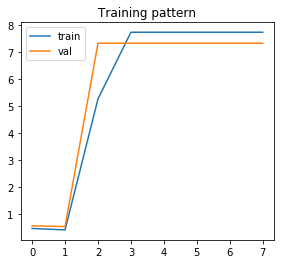

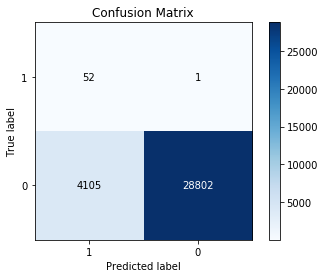

For Test year 2016
F1 Score 0.47119073415980633
F2 Score 0.45668607994979266
F1_w Score 0.9397612703576964
F2_w Score 0.45668607994979266
Precision 0.999852430109655
Precision_w 0.999852430109655
Recall 0.9326672076190272
Recall_w 0.8866243015902253
MCC Score 0.032764657238031326


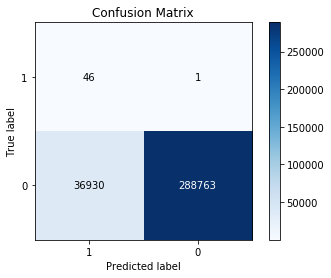

	Warned about fire border 3
	Warned about fire feather
	Warned about fire roblar
	Warned about fire pala
32.56666666666667 -116.64166663333334 Missed Fire border 3
32.56666666666667 -116.59999996666667 Missed Fire border 3
32.608333333333334 -116.64166663333334 Missed Fire border 3
33.400000000000006 -117.09999996666667 Missed Fire pala


In [29]:
train_n_test_model(2016)

No. of Fires in Train set are 286
No. of Fire sequences in Train set are 2155
No. of no-fire sequences in Train set are 648591
No. of Fires in Test set are 8
No. of Fire sequences in Test set are 12
No. of no-fire sequences in Test set are 32919
Fires in Test are ['2018_aliso', '2018_martinez', '2018_monte', '2018_pasqual', '2018_recycle', '2018_ribbon', '2018_rock', '2018_west']
{0: 0.5017069319632648, 1: 146.96160794941284}
Train on 585671 samples, validate on 65075 samples
Epoch 1/25
 - 194s - loss: 0.4485 - val_loss: 0.4870
Epoch 2/25
 - 201s - loss: 0.3774 - val_loss: 0.5067
Epoch 3/25
 - 193s - loss: 0.3628 - val_loss: 0.5617
Epoch 4/25
 - 207s - loss: 0.3543 - val_loss: 0.5615
Epoch 5/25
 - 169s - loss: 0.3427 - val_loss: 0.5403
Epoch 6/25
 - 197s - loss: 0.3430 - val_loss: 0.5222
Epoch 7/25
 - 191s - loss: 0.3276 - val_loss: 0.5318
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
****Building LSTM of lag	10;with input_node	10;and hidden_node	10

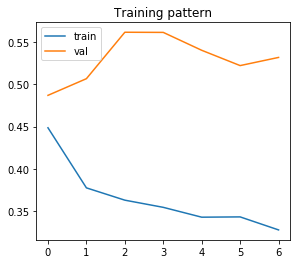

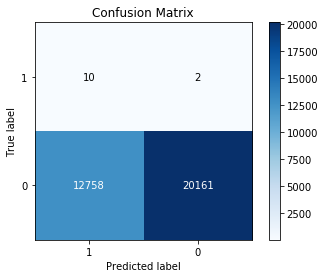

For Test year 2018
F1 Score 0.3887590676402386
F2 Score 0.34308290459655116
F1_w Score 0.7773204073039814
F2_w Score 0.34308290459655116
Precision 0.9999533796242136
Precision_w 0.9999533796242136
Recall 0.7345635875934056
Recall_w 0.6358011389872249
MCC Score 0.005925098067045582


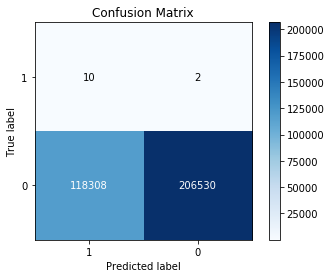

	Warned about fire recycle
	Warned about fire west
	Warned about fire monte
	Warned about fire pasqual
	Warned about fire rock
	Warned about fire aliso
	Warned about fire martinez
	Warned about fire ribbon
33.525000000000006 -117.76666663333334 Missed Fire aliso
33.525000000000006 -116.18333330000002 Missed Fire martinez


In [31]:
train_n_test_model(2018)

No. of Fires in Train set are 286
No. of Fire sequences in Train set are 2127
No. of no-fire sequences in Train set are 649498
No. of Fires in Test set are 8
No. of Fire sequences in Test set are 40
No. of no-fire sequences in Test set are 32012
Fires in Test are ['2017_black 2', '2017_capitan', '2017_eclipse', '2017_gate', '2017_jardine', '2017_lilac 5', '2017_lost', '2017_wildomar']
{0: 0.5016814460435975, 1: 149.18154761904762}
Train on 586462 samples, validate on 65163 samples
Epoch 1/25
 - 195s - loss: 0.5081 - val_loss: 0.4466
Epoch 2/25
 - 195s - loss: 7.6307 - val_loss: 7.9653
Epoch 3/25
 - 194s - loss: 7.7058 - val_loss: 7.9653
Epoch 4/25
 - 196s - loss: 7.7058 - val_loss: 7.9653
Epoch 5/25
 - 194s - loss: 7.7058 - val_loss: 7.9653
Epoch 6/25
 - 196s - loss: 7.7058 - val_loss: 7.9653
Epoch 7/25
 - 195s - loss: 7.7058 - val_loss: 7.9653
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
****Building LSTM of lag	10;with input_node	10;and hidden_no

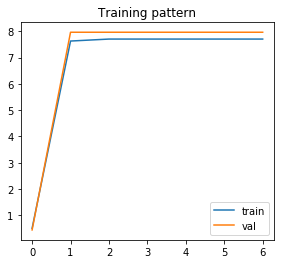

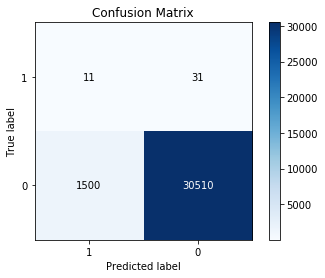

For Test year 2017
F1 Score 0.4741873504494998
F2 Score 0.46030136644262254
F1_w Score 0.9475772932295241
F2_w Score 0.46030136644262254
Precision 0.9997778005337501
Precision_w 0.9997778005337501
Recall 0.5878340414396108
Recall_w 0.9005910420193936
MCC Score 0.006516071195485992


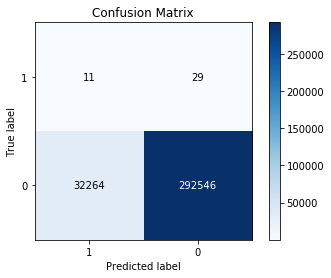

	Warned about fire gate
	Warned about fire eclipse
	Warned about fire capitan
	Warned about fire black 2
	Warned about fire lilac 5
	Warned about fire lost
	Warned about fire jardine
	Warned about fire wildomar
32.608333333333334 -116.89166663333334 Missed Fire gate
32.608333333333334 -116.84999996666667 Missed Fire gate
32.608333333333334 -116.80833330000002 Missed Fire gate
32.608333333333334 -116.47499996666667 Missed Fire eclipse
32.608333333333334 -116.43333330000002 Missed Fire eclipse
32.650000000000006 -116.89166663333334 Missed Fire gate
32.650000000000006 -116.84999996666667 Missed Fire gate
32.650000000000006 -116.80833330000002 Missed Fire gate
32.650000000000006 -116.47499996666667 Missed Fire eclipse
32.650000000000006 -116.43333330000002 Missed Fire eclipse
33.150000000000006 -116.80833330000002 Missed Fire black 2
33.233333333333334 -117.26666663333334 Missed Fire lilac 5
33.275000000000006 -117.26666663333334 Missed Fire lilac 5
33.275000000000006 -117.22499996666667 M

In [32]:
train_n_test_model(2017)

No. of Fires in Train set are 294
No. of Fire sequences in Train set are 2167
No. of no-fire sequences in Train set are 649471
No. of Fires in Test set are 0
No. of Fire sequences in Test set are 0
No. of no-fire sequences in Test set are 32039
Fires in Test are []
{0: 0.5017138580746892, 1: 146.36972147349505}
Train on 586474 samples, validate on 65164 samples
Epoch 1/25
 - 258s - loss: 0.5162 - val_loss: 0.6162
Epoch 2/25
 - 264s - loss: 0.4173 - val_loss: 0.4999
Epoch 3/25
 - 264s - loss: 0.3806 - val_loss: 0.5019
Epoch 4/25
 - 247s - loss: 0.3617 - val_loss: 0.5418
Epoch 5/25
 - 256s - loss: 0.3552 - val_loss: 0.4449
Epoch 6/25
 - 275s - loss: 0.3480 - val_loss: 0.5145
Epoch 7/25
 - 260s - loss: 0.3634 - val_loss: 0.5170
Epoch 8/25
 - 266s - loss: 0.3314 - val_loss: 0.5097
Epoch 9/25
 - 262s - loss: 0.3404 - val_loss: 0.4958
Epoch 10/25
 - 246s - loss: 0.3099 - val_loss: 0.7326
Epoch 11/25
 - 252s - loss: 0.3095 - val_loss: 0.6124
Restoring model weights from the end of the best ep

C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


****Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 150};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.4659988666288876;and received F2_Score:	0.4477308394452807;and MCC_Score:	0.0;of CM	[[    0     0] [ 4080 27959]];



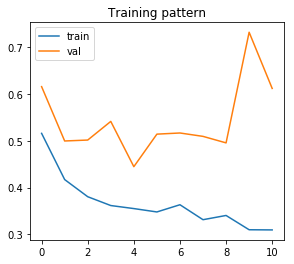

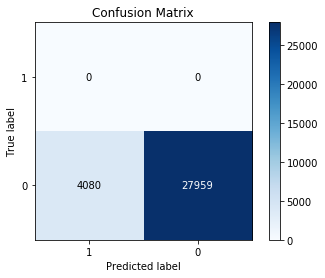

For Test year 2019
F1 Score 0.47005055605130974


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2 Score 0.4537433237608289
F1_w Score 0.9401011121026195


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F2_w Score 0.4537433237608289
Precision 1.0
Precision_w 1.0
Recall 0.4434862244112667


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall_w 0.8869724488225335


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC Score 0.0


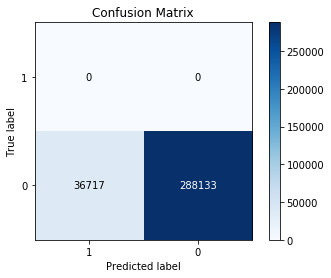

In [34]:
train_n_test_model(2019)